In [1]:
# https://www.kaggle.com/datasets/joealvarez/healthcare-reviews
import pandas as pd

data = pd.read_csv("/notebooks/healthcare.csv")
data.head()

,CompanyName,Review,Date,OwnershipType
0,united_american,United American has been fantastic. We have ha...,4/22/2023,Public
1,united_american,We've had very good luck with United American....,10/28/2022,Public
2,united_american,We've had a United American Insurance policy f...,10/12/2022,Public
3,united_american,We were with Cleveland Clinic and when they st...,9/1/2022,Public
4,united_american,My husband worked for a bank and we had a life...,5/30/2022,Public


In [2]:
print(data.shape)
print(data.describe())
print(data.info())
print(data.isna().sum())

(10743, 4)
               CompanyName                                             Review  \
count                10743                                              10741   
unique                  16                                              10740   
top     united_health_care  I never get questioned about what United Ameri...   
freq                  2094                                                  2   

             Date OwnershipType  
count       10743         10743  
unique       3914             3  
top     4/12/2019        Public  
freq           27          7427  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10743 entries, 0 to 10742
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CompanyName    10743 non-null  object
 1   Review         10741 non-null  object
 2   Date           10743 non-null  object
 3   OwnershipType  10743 non-null  object
dtypes: object(4)
memory usage: 335.8+ KB
None


In [3]:
data = data.dropna()
print(data.isna().sum())

CompanyName      0
Review           0
Date             0
OwnershipType    0
dtype: int64


<AxesSubplot: >

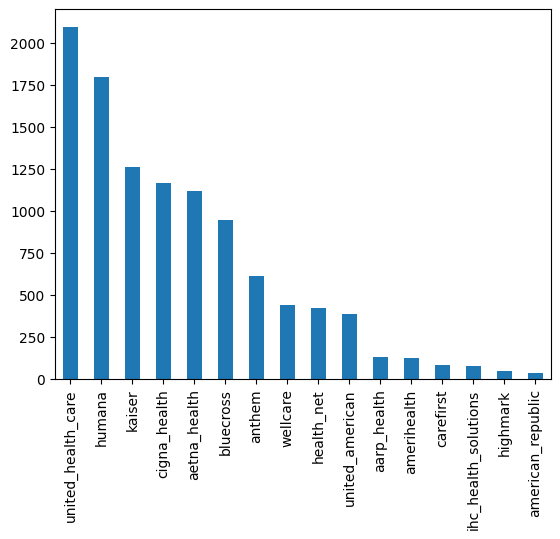

In [4]:
data['CompanyName'].value_counts().plot(kind='bar')

<AxesSubplot: xlabel='Date'>

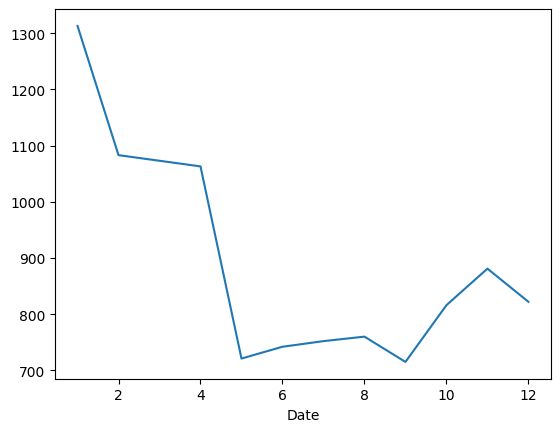

In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data.groupby(data['Date'].dt.month).size().plot(kind='line')

<AxesSubplot: >

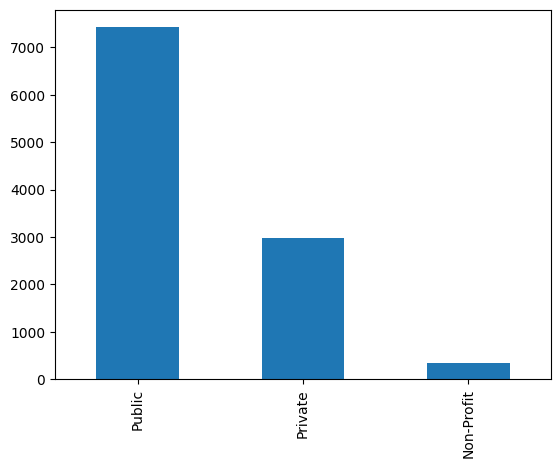

In [6]:
data['OwnershipType'].value_counts().plot(kind='bar')

# Sentiment Analysis

In [7]:
!pip install textblob vadersentiment tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 44.8 MB/s eta 0:00:00


In [28]:
from textblob import TextBlob

data['blob_score'] = data['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
print(data['blob_score'])


0        0.110357
1        0.258250
2        0.247266
3        0.046429
4        0.387013
           ...   
10738    0.101250
10739    0.023958
10740    0.024206
10741   -0.030769
10742    0.022222
Name: blob_score, Length: 10741, dtype: float64


In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
data['vader_score'] = data['Review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
print(data['vader_score'])


0       -0.3631
1        0.8912
2        0.9568
3        0.4686
4        0.9200
          ...  
10738   -0.2500
10739    0.4036
10740   -0.4504
10741   -0.9201
10742   -0.9206
Name: vader_score, Length: 10741, dtype: float64


In [14]:
def label_sentiment(row):
    if row['vader_score'] >= 0.05:
        return 'Positive'
    elif row['vader_score'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

data['vader_label'] = data.apply(label_sentiment, axis=1)
data['vader_label']


0        Negative
1        Positive
2        Positive
3        Positive
4        Positive
           ...   
10738    Negative
10739    Positive
10740    Negative
10741    Negative
10742    Negative
Name: vader_label, Length: 10741, dtype: object

In [30]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from tqdm.notebook import tqdm_notebook
import torch
tqdm_notebook.pandas()

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
model.eval()

def get_sentiment_bert(sentence):
    inputs = tokenizer.encode_plus(sentence, return_tensors="pt", max_length=512, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs[0]
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    sentiment = torch.argmax(probabilities, dim=1).item()
    return sentiment

# Use TQDM progress bar
data['BERT_Score'] = data['Review'].progress_apply(lambda x: get_sentiment_bert(str(x)))

# Display results
data[['Review', 'BERT_Score']].head()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

  0%|          | 0/10741 [00:00<?, ?it/s]

,Review,BERT_Score
0,United American has been fantastic. We have ha...,0
1,We've had very good luck with United American....,4
2,We've had a United American Insurance policy f...,4
3,We were with Cleveland Clinic and when they st...,1
4,My husband worked for a bank and we had a life...,1


In [31]:
def bert_score_to_polarity(score):
    # Assuming your scores are from 0 (Very Negative) to 4 (Very Positive)
    return (score - 2) / 2  # This will give you a score from -1 to 1

data['BERT_Polarity'] = data['BERT_Score'].apply(bert_score_to_polarity)
print(data['BERT_Polarity'])


0       -1.0
1        1.0
2        1.0
3       -0.5
4       -0.5
        ... 
10738    1.0
10739    0.0
10740   -1.0
10741   -0.5
10742   -0.5
Name: BERT_Polarity, Length: 10741, dtype: float64


In [32]:
data[['BERT_Polarity', 'vader_score', 'blob_score']].corr()


,BERT_Polarity,vader_score,blob_score
BERT_Polarity,1.000000,0.011543,-0.017524
vader_score,0.011543,1.000000,0.428947
blob_score,-0.017524,0.428947,1.000000


In [33]:
data['ensemble_score'] = data[['BERT_Polarity', 'vader_score', 'blob_score']].mean(axis=1)
print(data['ensemble_score'])


0       -0.417581
1        0.716483
2        0.734689
3        0.005010
4        0.269004
           ...   
10738    0.283750
10739    0.142519
10740   -0.475398
10741   -0.483623
10742   -0.466126
Name: ensemble_score, Length: 10741, dtype: float64


In [34]:
print(data['ensemble_score'].min())
print(data['ensemble_score'].max())

-0.9994999999999999
0.9389222222222222


In [35]:
def convert_to_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

data['ensemble_label'] = data['ensemble_score'].apply(convert_to_sentiment)
print(data['ensemble_label'])


0        Negative
1        Positive
2        Positive
3         Neutral
4        Positive
           ...   
10738    Positive
10739    Positive
10740    Negative
10741    Negative
10742    Negative
Name: ensemble_label, Length: 10741, dtype: object


<AxesSubplot: >

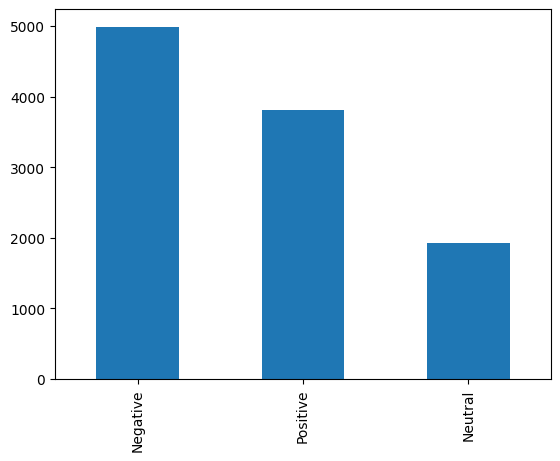

In [36]:
data['ensemble_label'].value_counts().plot(kind='bar')

<AxesSubplot: >

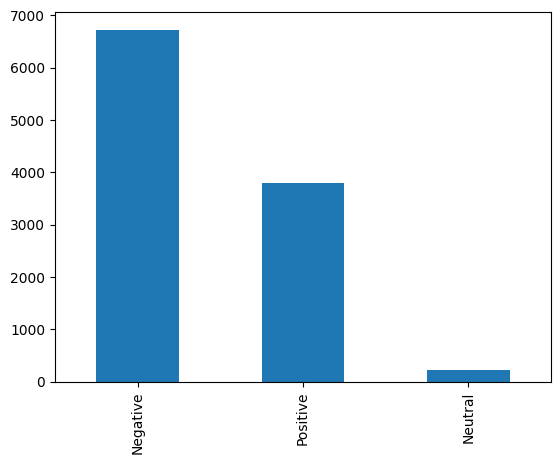

In [37]:
data['vader_label'].value_counts().plot(kind='bar')

# Sentence-based Sentiment Analysis

In [46]:
data['Review']

0        United American has been fantastic. We have ha...
1        We've had very good luck with United American....
2        We've had a United American Insurance policy f...
3        We were with Cleveland Clinic and when they st...
4        My husband worked for a bank and we had a life...
                               ...                        
10738    Abusive unexplained rate increases and unexpla...
10739    Despite a deductible of $4000 and a co-insuran...
10740    I have 2 complaints against this company. We s...
10741    We had insurance on both our sons, one who liv...
10742    First off, the reason I cancelled this company...
Name: Review, Length: 10741, dtype: object

In [50]:
import pandas as pd
import nltk
from textblob import TextBlob

nltk.download('punkt')

# Step 1: Tokenize the reviews into sentences
sentences_series = data['Review'].apply(nltk.sent_tokenize)

# Step 2: Convert the exploded series into a list of sentences
sentences_list = [sentence for sublist in sentences_series for sentence in sublist]

# Step 3: Create a new dataframe from this list
df_sentences = pd.DataFrame(sentences_list, columns=['Sentence'])

# Check the new dataframe
print("Tokenized Sentences (Before filtering):")
print(df_sentences)

# Function to get sentiment
def get_sentiment(sentence):
    # Check if sentence has more than 3 words
    if len(sentence.split()) > 3:
        return TextBlob(sentence).sentiment.polarity
    else:
        return None

# Apply the function to the dataframe
df_sentences['Sentiment'] = df_sentences['Sentence'].apply(get_sentiment)

# Remove rows with None sentiment (i.e., sentences with 3 words or less)
df_sentences.dropna(subset=['Sentiment'], inplace=True)

# Display the dataframe after sentiment analysis
print("\nSentences after Sentiment Analysis:")
print(df_sentences)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenized Sentences (Before filtering):
                                                 Sentence
0                     United American has been fantastic.
1       We have had not one bit of trouble collecting ...
2                              So, we're extremely happy.
3       I've had a lot of illnesses so many times and ...
4       But United have not questioned and they have b...
...                                                   ...
121124  I called the bank and put a stop payment, whic...
121125  I called them again the next day and spoke wit...
121126  I am willing to eat the $25 stop payment, just...
121127  But I do expect to be reimubrsed by the compan...
121128  I can't help but wonder, had I been a satisfie...

[121129 rows x 1 columns]

Sentences after Sentiment Analysis:
                                                 Sentence  Sentiment
0                     United American has been fantastic.   0.200000
1       We have had not one bit of trouble collecting ...  -0.

In [51]:
def label_sentiment(polarity):
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

# Apply the function to get sentiment labels
df_sentences['Sentiment_Label'] = df_sentences['Sentiment'].apply(label_sentiment)

# Display the dataframe with sentiment labels
print(df_sentences)


                                                 Sentence  Sentiment  \
0                     United American has been fantastic.   0.200000   
1       We have had not one bit of trouble collecting ...  -0.200000   
2                              So, we're extremely happy.   0.800000   
3       I've had a lot of illnesses so many times and ...   0.206250   
4       But United have not questioned and they have b...  -0.250000   
...                                                   ...        ...   
121124  I called the bank and put a stop payment, whic...   0.000000   
121125  I called them again the next day and spoke wit...   0.000000   
121126  I am willing to eat the $25 stop payment, just...   0.250000   
121127  But I do expect to be reimubrsed by the compan...   0.000000   
121128  I can't help but wonder, had I been a satisfie...  -0.133333   

       Sentiment_Label  
0             positive  
1             negative  
2             positive  
3             positive  
4         

# Keyword Extraction

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


positive_reviews = df_sentences[df_sentences['Sentiment_Label'] == 'positive']['Sentence']
negative_reviews = df_sentences[df_sentences['Sentiment_Label'] == 'negative']['Sentence']
neutral_reviews = df_sentences[df_sentences['Sentiment_Label'] == 'neutral']['Sentence']

positive_reviews_text = ' '.join(positive_reviews.dropna())
negative_reviews_text = ' '.join(negative_reviews.dropna())
neutral_reviews_text = ' '.join(neutral_reviews.dropna())


# We'll still use the positive_reviews_text you generated earlier

# Instantiate the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,3), max_features=20)

# Fit and transform the positive reviews
X = vectorizer.fit_transform([positive_reviews_text])

# Get the terms (keywords/phrases)
terms = vectorizer.get_feature_names_out()

print("\nTop Keywords/Phrases in Positive Reviews using TF-IDF:")
for term in terms:
    print(term)




Top Keywords/Phrases in Positive Reviews using TF-IDF:
blue cross
blue shield
care physician
customer service
health care
health insurance
health net
insurance companies
insurance company
make sure
phone calls
primary care
primary care physician
right source
social security
united american
united health
united health care
united healthcare
year old


1. "called", "phone", "told", "said": These terms indicate interaction, possibly with customer service or support. This suggests that people might be discussing their interactions with representatives of the insurance companies.

2. "care", "doctor", "health": These are directly related to healthcare services. Customers might be discussing the quality of healthcare, their interactions with doctors, or the ease of getting medical care.

3. "company", "insurance", "plan", "coverage": These terms are indicative of discussions around the insurance plans themselves - the coverage they offer, the cost, the reliability, etc.

4. "kaiser", "humana", "united": These are company names and reinforce the fact that people are discussing specific insurance providers.

5. "service": This might be related to customer service, or the overall service provided by the insurance company.

6. "time": Could relate to waiting times, the time it takes to process claims, or the duration of coverage.

7. "pay": Likely refers to payments - either monthly premiums, co-pays, or the amount the insurance pays out on claims.

# Checking Adjective Pairings

In [73]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_adj_pairings(doc, keywords):
    adj_pairings = {}
    for token in doc:
        if token.text in keywords and token.pos_ == 'NOUN':
            for child in token.children:
                if child.pos_ == 'ADJ':
                    pair = (child.text, token.text)
                    adj_pairings[pair] = adj_pairings.get(pair, 0) + 1
    return adj_pairings

def split_text(text, char_limit=800000):  # Using a character limit a bit less than spaCy's limit to be safe
    chunks = []
    while len(text) > char_limit:
        limit_index = text[:char_limit].rfind(' ')  # Find the last space within the char_limit to split the text
        chunks.append(text[:limit_index])
        text = text[limit_index:]  # The remaining text
    chunks.append(text)
    return chunks

chunks = split_text(positive_reviews_text)

keywords = ["called", "care", "company", "coverage", "doctor", "health", "insurance", "plan", "service", "time", "pay"]
all_pairings = {}

for chunk in chunks:
    doc = nlp(chunk)
    pairings = extract_adj_pairings(doc, keywords)
    
    # Aggregate the pairings
    for pair, count in pairings.items():
        all_pairings[pair] = all_pairings.get(pair, 0) + count

# Sort by frequency
sorted_pairings = sorted(all_pairings.items(), key=lambda x: x[1], reverse=True)

for pairing, count in sorted_pairings:
    print(f"Adjective-Noun Pairing: {pairing[0]}-{pairing[1]}, Count: {count}")


Adjective-Noun Pairing: primary-care, Count: 217
Adjective-Noun Pairing: first-time, Count: 206
Adjective-Noun Pairing: primary-doctor, Count: 121
Adjective-Noun Pairing: new-plan, Count: 105
Adjective-Noun Pairing: new-insurance, Count: 82
Adjective-Noun Pairing: new-doctor, Count: 74
Adjective-Noun Pairing: medical-care, Count: 62
Adjective-Noun Pairing: medical-insurance, Count: 52
Adjective-Noun Pairing: primary-insurance, Count: 46
Adjective-Noun Pairing: new-company, Count: 40
Adjective-Noun Pairing: full-time, Count: 38
Adjective-Noun Pairing: much-time, Count: 34
Adjective-Noun Pairing: more-time, Count: 33
Adjective-Noun Pairing: urgent-care, Count: 33
Adjective-Noun Pairing: good-health, Count: 33
Adjective-Noun Pairing: best-plan, Count: 32
Adjective-Noun Pairing: dental-insurance, Count: 32
Adjective-Noun Pairing: other-insurance, Count: 32
Adjective-Noun Pairing: second-time, Count: 32
Adjective-Noun Pairing: long-time, Count: 30
Adjective-Noun Pairing: good-insurance, Cou

# Topic Modeling

In [77]:
!pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 58.8 MB/s eta 0:00:0000:0100:01


In [84]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 1. Pre-processing
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=1000)
X = vectorizer.fit_transform(positive_reviews.tolist())

# 2. Run LDA
number_of_topics = 5  # You can change this to identify more or fewer topics
lda = LatentDirichletAllocation(n_components=number_of_topics, max_iter=10, random_state=42)
lda.fit(X)

# 3. View Topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print("\nTopics in LDA model:")
print_top_words(lda, vectorizer.get_feature_names_out(), 10)



Topics in LDA model:
Topic #0: told called right said time phone doctor information days new
Topic #1: insurance company good health service care customer united kaiser healthcare
Topic #2: doctor pay year month years pain old medication went high
Topic #3: make sure know better like don just people way live
Topic #4: plan new insurance network coverage medical blue medicare primary care



Topic 0: This seems to revolve around communication and interactions, possibly related to appointments, inquiries, and consultations. Words like "told", "called", "phone", and "information" suggest dialogues and information exchange.

Topic 1: This topic looks at insurance companies and the broader concept of healthcare, with a focus on customer service and care quality. Brands or big players like "united" and "kaiser" appear, hinting at mentions of specific insurance companies.

Topic 2: This topic dives into medical treatments, durations, and experiences. Words like "pain", "medication", "year", and "month" suggest discussions about long-term treatments or conditions.

Topic 3: This is more of a general topic, focusing on opinions, suggestions, and personal feelings. Words like "make sure", "know", "better", and "like" indicate a more opinionated content, possibly from people sharing their thoughts and advice.

Topic 4: This focuses on insurance plans, coverage, and specific terms related to medical insurance. "Plan", "network", "coverage", and "medicare" provide insights into discussions about insurance policies and options.

# Named Entity Recognition (NER)

In [86]:
import spacy
from collections import defaultdict

# Load spaCy NER model
nlp = spacy.load('en_core_web_sm')

# Create a dictionary to store entities and their counts
entity_counts = defaultdict(int)

# Process each review and update the entity counts
for review in reviews_topic2:
    doc = nlp(review)
    for ent in doc.ents:
        entity_counts[(ent.text, ent.label_)] += 1

# Sort entities by count and organize by type
sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)
organized_entities = defaultdict(list)

for (entity, label), count in sorted_entities:
    organized_entities[label].append((entity, count))

# Display top entities for each type
for label, entities in organized_entities.items():
    print(f"\n{label}s:")
    for entity, count in entities[:10]:  # Display top 10 entities for each type
        print(f"{entity} ({count})")



ORGs:
Kaiser (323)
Humana (147)
United Health Care (112)
United Healthcare (95)
United American (93)
Aetna (84)
UHC (71)
Medicare (66)
United (48)
Health Net (43)

GPEs:
Cigna (149)
KP (17)
US (12)
America (9)
California (5)
Philippines (5)
VA (4)
USA (4)
Illinois (4)
Florida (4)

ORDINALs:
first (129)
First (26)
third (9)
second (7)
Firstly (2)
Third (2)
fourth (1)
14th (1)
1st (1)
3rd (1)

CARDINALs:
one (87)
two (21)
zero (19)
2 (14)
three (12)
3 (10)
1 (8)
One (7)
5 (7)
4 (7)

LANGUAGEs:
English (42)
english (2)

PERSONs:
Anthem (41)
Kaiser Permanente (28)
Obama (8)
Wellcare (7)
KP (5)
Golden Rule (3)
Optum (2)
Ambetter (2)
Sylvia (2)
Allwell (2)

TIMEs:
hours (32)
many hours (12)
an hour (9)
2 hours (5)
hours and hours (4)
more than an hour (3)
24 hours (3)
last night (2)
24 hour (2)
hours upon hours (2)

DATEs:
many years (26)
years (22)
today (16)
this year (15)
next year (12)
the years (11)
last year (10)
several years (9)
daily (9)
monthly (8)

WORK_OF_ARTs:
Golden Rule (26)
